In [3]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])
training_dataset=datasets.FashionMNIST(
    root="/home/sachchida/gitrepo/Deeplearning/data/fashion",
    train=True,
    download=True,
    transform=transform
)
testing_dataset=datasets.FashionMNIST(
    root="/home/sachchida/gitrepo/Deeplearning/data/fashion",
    train=False,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 106kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 859kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 31.0MB/s]


In [15]:
train_loader=DataLoader(training_dataset,shuffle=True,batch_size=64)
test_loader=DataLoader(testing_dataset,shuffle=True,batch_size=64)

In [16]:
import torch.nn as nn
import torch.nn.functional as F


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FashionCNN().to(device)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --------------------------------------------------
# Train Function
# --------------------------------------------------
def train(model, loader):
    ## put the model in training mode
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        ## clear the gradient from prev batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ### Update the weights at each batch
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


optimizer.zero_grad() clears stored gradients
torch.no_grad() prevents gradient computation
| Aspect                | `optimizer.zero_grad()` | `with torch.no_grad():`          |
| --------------------- | ----------------------- | -------------------------------- |
| What it does          | Clears `.grad` values   | Stops building computation graph |
| Affects               | Past gradients          | Current operations               |
| Used in               | Training loop           | Evaluation / inference           |
| Saves memory          | ❌ No                    | ✅ Yes                            |
| Required for training | ✅ Yes                   | ❌ No                             |


In [20]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [21]:
epochs = 10
for epoch in range(epochs):
    loss = train(model, train_loader)
    acc = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Test Acc: {acc:.2f}%")

Epoch 1/10 | Loss: 0.2286 | Test Acc: 98.51%
Epoch 2/10 | Loss: 0.0888 | Test Acc: 98.79%
Epoch 3/10 | Loss: 0.0649 | Test Acc: 99.07%
Epoch 4/10 | Loss: 0.0546 | Test Acc: 98.93%
Epoch 5/10 | Loss: 0.0432 | Test Acc: 99.20%
Epoch 6/10 | Loss: 0.0386 | Test Acc: 99.30%
Epoch 7/10 | Loss: 0.0341 | Test Acc: 99.16%
Epoch 8/10 | Loss: 0.0309 | Test Acc: 99.22%
Epoch 9/10 | Loss: 0.0269 | Test Acc: 99.22%
Epoch 10/10 | Loss: 0.0262 | Test Acc: 99.16%


In [23]:
import torch

def predict_image(model, image, device):
    model.eval()  # evaluation mode

    with torch.no_grad():  # no gradients needed
        image = image.unsqueeze(0)        # add batch dimension
        image = image.to(device)

        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()


In [22]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]


In [ ]:
# Get one image from test dataset
image, label = testing_dataset[:10]

pred_idx = predict_image(model, image, device)

print("True Label     :", class_names[label])
print("Predicted Label:", class_names[pred_idx])


True Label     : Sneaker
Predicted Label: Sneaker


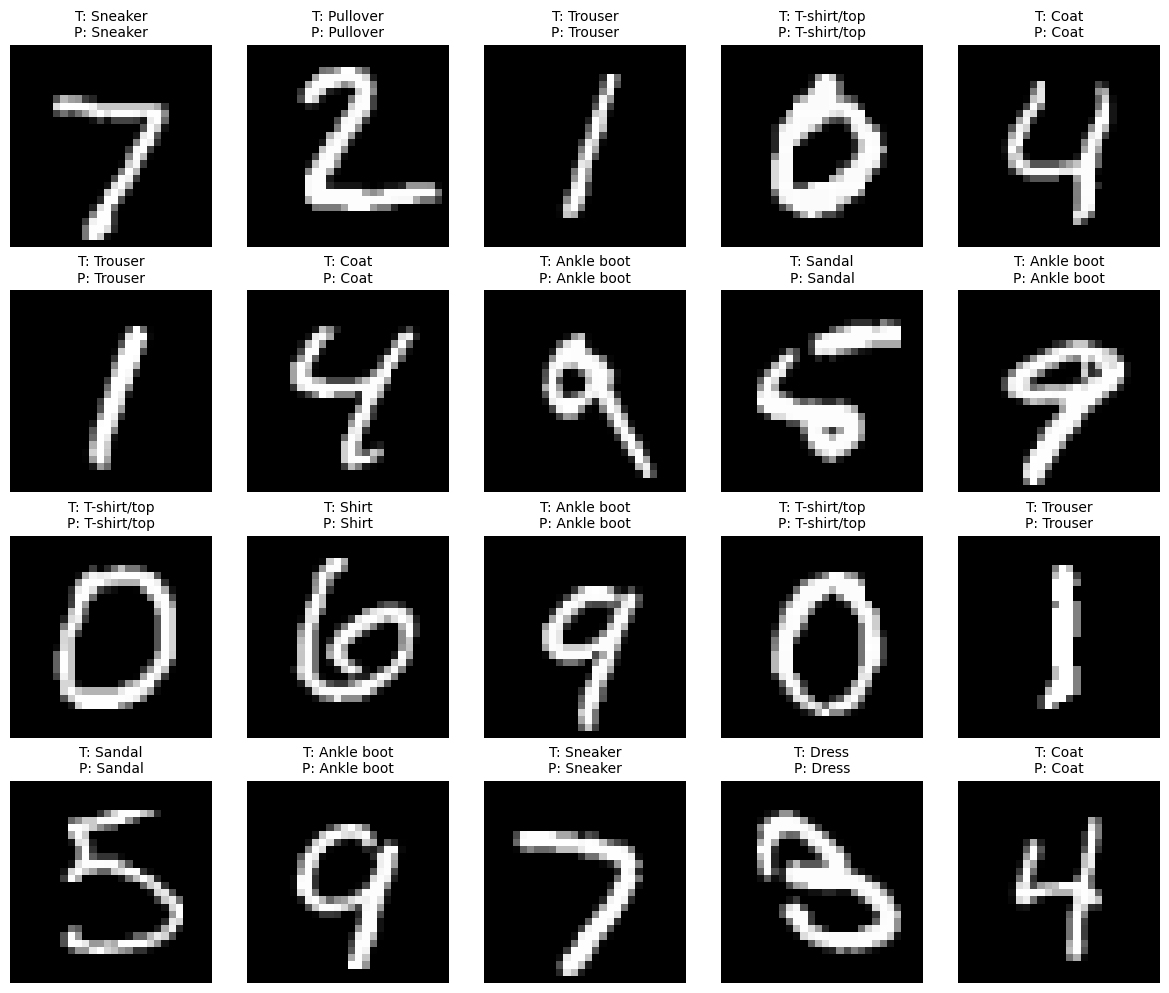

In [25]:
import torch
import matplotlib.pyplot as plt

# Ensure evaluation mode
model.eval()

fig, axes = plt.subplots(4, 5, figsize=(12, 10))

with torch.no_grad():
    for i in range(20):
        image, label = testing_dataset[i]
        image = image.to(device)

        # Add batch dimension
        image_batch = image.unsqueeze(0)

        # Predict
        output = model(image_batch)
        _, pred = torch.max(output, 1)

        # Plot
        ax = axes[i // 5, i % 5]
        ax.imshow(image.cpu().squeeze(), cmap="gray")
        ax.set_title(
            f"T: {class_names[label]}\nP: {class_names[pred.item()]}",
            fontsize=10
        )
        ax.axis("off")

plt.tight_layout()
plt.show()
